# Single model pFBA predictions

In [5]:
import reframed
import pandas as pd
import numpy as np

import seaborn as sns

import os
import json

import copy

import sys 
sys.path.append("../functions/")
import general_functions as general_func
import MAG_environments

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data

In [7]:
all_mags_paper = general_func.read_allmags_data()

In [8]:
with open("../output/relevant_MAGs_99.txt") as text_file:
    relevant_MAGs = text_file.read().split("\n")

relevant_MAGs = [string.replace("\t","") for string in relevant_MAGs]


In [9]:
MAG2community_id = pd.read_csv("../output/MAG2community_id.tsv",sep="\t",header=None)


#### Load models

In [11]:
GEMs_dict = {}

directory = os.fsencode("../output/GEMs/GEMs_no_constraints/")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".xml"):
        print(filename)

        GEMs_dict[filename[:-4]]= reframed.load_cbmodel("../output/GEMs/GEMs_no_constraints/"+filename)


CH7-bin.18.xml
CH15-bin.7.xml
CH13-bin.0.xml
CH1-bin.4.xml
CH13-bin.1.xml
CH13-bin.11.xml
CH15-bin.6.xml
CH7-bin.2.xml
CH13-bin.13.xml
CH1-bin.10.xml
CH1-bin.6.xml
CH13-bin.2.xml
CH13-bin.12.xml
CH15-bin.5.xml
CH7-bin.1.xml
CH15-bin.1.xml
CH1-bin.3.xml
CH13-bin.17.xml
CH15-bin.0.xml
CH7-bin.4.xml
CH7-bin.23.xml
CH7-bin.6.xml
CH15-bin.22.xml
CH15-bin.2.xml
CH1-bin.1.xml
CH13-bin.4.xml
CH13-bin.14.xml
CH15-bin.23.xml
CH7-bin.20.xml
CH8-bin.8.xml
CH8-bin.9.xml
CH8-bin.25.xml
CH14-bin.4.xml
CH14-bin.1.xml
CH8-bin.21.xml
CH14-bin.2.xml
CH8-bin.22.xml
CH8-bin.2.xml
CH8-bin.29.xml
CH8-bin.7.xml
CH8-bin.6.xml
CH3-bin.2.xml
CH8-bin.14.xml
CH8-bin.16.xml
CH3-bin.0.xml
CH8-bin.5.xml
CH3-bin.1.xml
CH8-bin.17.xml
CH7-bin.11.xml
CH9-bin.1.xml
CH15-bin.12.xml
CH13-bin.25.xml
CH15-bin.13.xml
CH9-bin.0.xml
CH7-bin.12.xml
CH9-bin.2.xml
CH7-bin.9.xml
CH15-bin.10.xml
CH7-bin.8.xml
CH7-bin.13.xml
CH7-bin.17.xml
CH15-bin.8.xml
CH15-bin.15.xml
CH7-bin.16.xml
CH9-bin.6.xml
CH9-bin.4.xml
CH15-bin.17.xml
CH1-bi

### Define environments

In [12]:
syncon_environments = MAG_environments.community_syncon_environments()

syncon_environments.keys()

dict_keys(['CD_A', 'CD_P', 'CD_X', 'CM_A', 'CM_P', 'CM_X', 'M_P', 'M_X'])

### FBA growth predictions

In [13]:
community_groups = MAG2community_id.set_index(0).groupby(1).groups

In [14]:
FBA_growth = {}
for community_id, MAGs in community_groups.items(): 
    FBA_growth[community_id]={}
    for MAG in MAGs:
        if MAG not in relevant_MAGs:
            continue
            
        print(MAG)
        model = GEMs_dict[MAG]
        syncon_environments[community_id].apply(model,inplace=True,exclusive=True,warning=False)
        sol = reframed.FBA(model)
        
        if sol is None:
            FBA_growth[community_id][MAG]=None
        else:
            FBA_growth[community_id][MAG]=sol

CH13-bin.12
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
CH13-bin.11
CH13-bin.4
CH13-bin.14
CH13-bin.25
CH13-bin.17
CH13-bin.0
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH15-bin.0
CH15-bin.23
CH15-bin.1
CH15-bin.7
CH15-bin.8
CH15-bin.22
CH15-bin.6
CH15-bin.17
CH15-bin.16
CH15-bin.13
CH15-bin.12
CH15-bin.5
CH15-bin.10
CH15-bin.15
CH15-bin.2
CH14-bin.1
CH14-bin.2
CH14-bin.4
CH8-bin.22
CH8-bin.17
CH8-bin.7
CH8-bin.2
CH8-bin.6
CH8-bin.25
CH8-bin.5
CH8-bin.9
CH8-bin.16
CH8-bin.21
CH8-bin.8
CH8-bin.29
CH8-bin.14
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.2
CH7-bin.8
CH7-bin.18
CH7-bin.1
CH7-bin.17
CH7-bin.4
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH9-bin.0
CH9-bin.6
CH9-bin.5
CH9-bin.1
CH9-bin.2
CH9-bin.4
CH1-bin.6
CH1-bin.9
CH1-bin.3
CH1-bin.4
CH1-bin.8
CH1-bin.1
CH1-bin.10
CH3-bin.2
CH3-bin.1
CH3-bin.0


In [15]:
mags_growth = pd.Series({GEM:sol.fobj for GEM_sol_dict in FBA_growth.values() for GEM,sol in GEM_sol_dict.items()})

In [16]:
assert len(mags_growth.index)==72

#### Top 99

In [17]:
# Add the source and substrate to this data
growth_community_df = pd.concat([all_mags_paper.loc[:,["Source","Substrate"]],mags_growth],axis=1)

# Change from float to False or positive
growth_community_df.dropna(inplace=True)
growth_community_df["Grows"] = growth_community_df[0].map(lambda x:x>1e-6)

# Drop the growth float column
growth_community_df.drop(0,axis=1,inplace=True)

# Group by source and substrate
growth_community_grouped_df = growth_community_df.groupby(["Source","Substrate"]).value_counts()

# Prepare for plotting
growth_community_grouped_df = growth_community_grouped_df.unstack()
growth_community_grouped_df.columns = ["# not growing","# growing"]

In [18]:
assert growth_community_grouped_df.sum().sum()==72

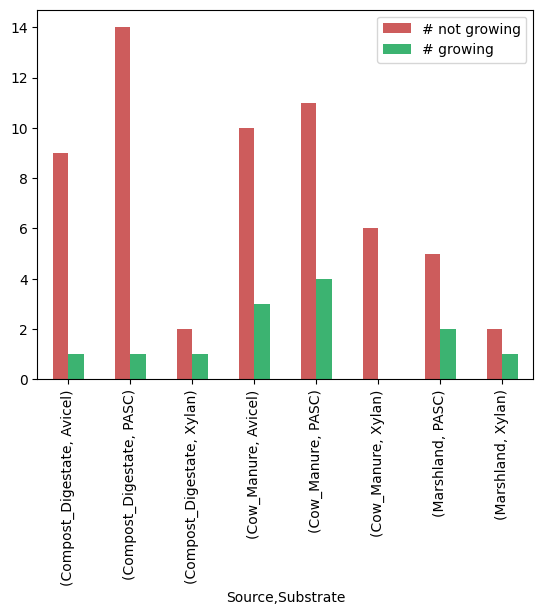

In [19]:
import matplotlib.pyplot as plt

ax = growth_community_grouped_df.plot(kind="bar",color=['indianred','mediumseagreen'])

#### Top 95

In [20]:
# Add the source and substrate to this data
all_mags_paper_95 = all_mags_paper[all_mags_paper["new_coverage"]>5]
growth_community_df = pd.concat([all_mags_paper_95.loc[:,["Source","Substrate"]],pd.Series({GEM:sol.fobj for sour_sub,GEM_sol_dict in FBA_growth.items() for GEM,sol in GEM_sol_dict.items()})],axis=1)

# Change from float to False or positive
growth_community_df.dropna(inplace=True)
growth_community_df["Grows"] = growth_community_df[0].map(lambda x:x>1e-6)

# Drop the growth float column
growth_community_df.drop(0,axis=1,inplace=True)

# Group by source and substrate
growth_community_grouped_df = growth_community_df.groupby(["Source","Substrate"]).value_counts()

# Prepare for plotting
growth_community_grouped_df = growth_community_grouped_df.unstack()
growth_community_grouped_df.columns = ["# not growing","# growing"]

In [21]:
assert growth_community_grouped_df.sum().sum()==28

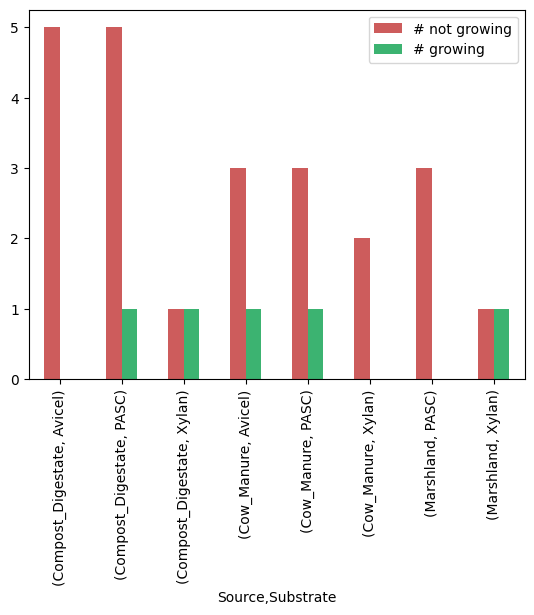

In [22]:
import matplotlib.pyplot as plt

ax = growth_community_grouped_df.plot(kind="bar",color=['indianred','mediumseagreen'])

### FBA production prediction

In [23]:
FBA_production = {}

interesting_compounds = ["etoh","lac__L","ac","ppa","ppoh","but","2mpa","isobuta","ibt","pta","3mb","hxa","isocap","4oxptn"]


for community_id, MAGs in community_groups.items(): 
    FBA_production[community_id]={}
    
    for MAG in MAGs:
        if MAG not in relevant_MAGs:
            continue
        print(MAG)
            
        model = GEMs_dict[MAG]
        syncon_environments[community_id].apply(model,inplace=True,exclusive=True,warning=False)
        
        FBA_production[community_id][MAG] = {}
        
        for met in interesting_compounds:
            if "R_EX_"+met+"_e" not in model.get_exchange_reactions():
                FBA_production[community_id][MAG][met]=None
                continue
            
            sol = reframed.FBA(model,objective={"R_EX_"+met+"_e":1})

            if sol is None:
                FBA_production[community_id][MAG][met]=None
            else:
                FBA_production[community_id][MAG][met]=sol.fobj

CH13-bin.12
CH13-bin.11
CH13-bin.4
CH13-bin.14
CH13-bin.25
CH13-bin.17
CH13-bin.0
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH15-bin.0
CH15-bin.23
CH15-bin.1
CH15-bin.7
CH15-bin.8
CH15-bin.22
CH15-bin.6
CH15-bin.17
CH15-bin.16
CH15-bin.13
CH15-bin.12
CH15-bin.5
CH15-bin.10
CH15-bin.15
CH15-bin.2
CH14-bin.1
CH14-bin.2
CH14-bin.4
CH8-bin.22
CH8-bin.17
CH8-bin.7
CH8-bin.2
CH8-bin.6
CH8-bin.25
CH8-bin.5
CH8-bin.9
CH8-bin.16
CH8-bin.21
CH8-bin.8
CH8-bin.29
CH8-bin.14
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.2
CH7-bin.8
CH7-bin.18
CH7-bin.1
CH7-bin.17
CH7-bin.4
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH9-bin.0
CH9-bin.6
CH9-bin.5
CH9-bin.1
CH9-bin.2
CH9-bin.4
CH1-bin.6
CH1-bin.9
CH1-bin.3
CH1-bin.4
CH1-bin.8
CH1-bin.1
CH1-bin.10
CH3-bin.2
CH3-bin.1
CH3-bin.0


In [24]:
# Add the source and substrate to this data
prod_sour_sub_df= pd.concat([all_mags_paper.loc[:,["Source","Substrate"]],pd.DataFrame({GEM:sol for sour_sub,GEM_sol_dict in FBA_production.items() for GEM,sol in GEM_sol_dict.items()}).transpose()],axis=1)

prod_sour_sub_df.fillna(0,inplace=True)

# Change from floats to binary
prod_sour_sub_df_bools =  prod_sour_sub_df.iloc[:,:2]
prod_sour_sub_df_bools = pd.concat([prod_sour_sub_df_bools,prod_sour_sub_df.iloc[:,2:].map(lambda x:x>1e-6)],axis=1)

In [25]:
assert prod_sour_sub_df_bools.shape[0]==72
assert prod_sour_sub_df_bools.shape[1]==len(interesting_compounds)+2

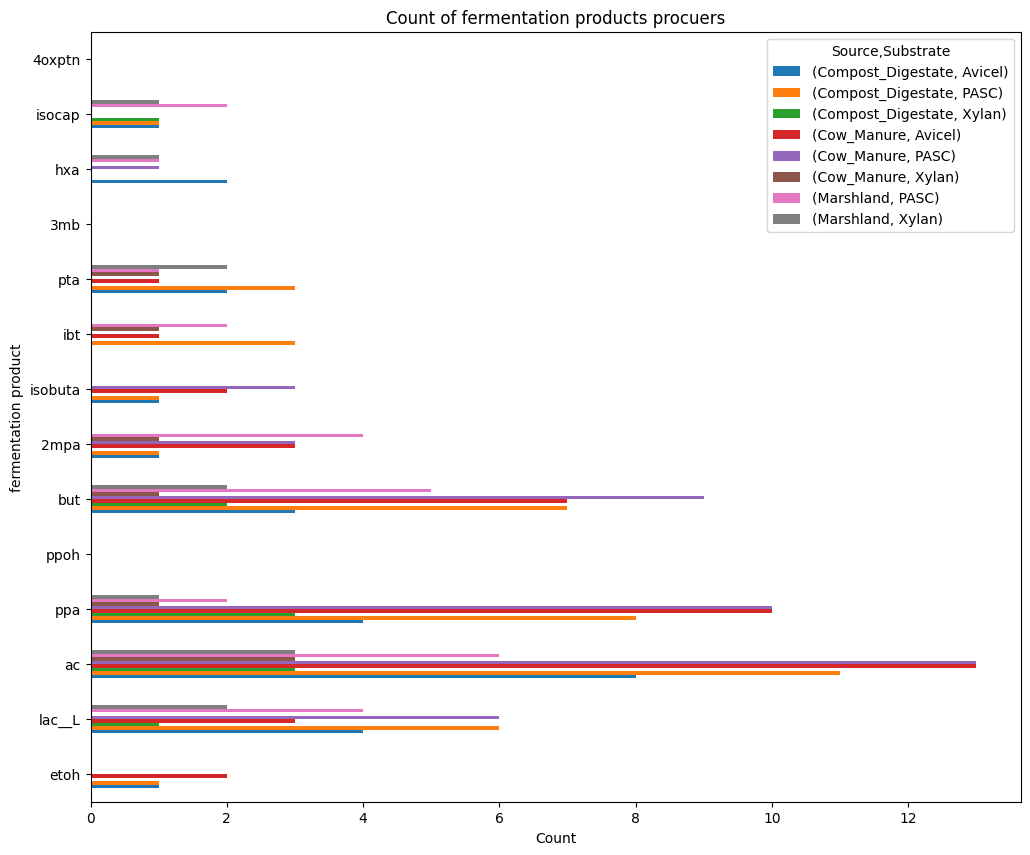

In [26]:
prod_sour_sub_df_bools.groupby(["Source","Substrate"]).sum().transpose().plot(kind="barh",figsize=(12,10))
plt.xlabel("Count")
plt.ylabel("fermentation product")
plt.title("Count of fermentation products procuers")
plt.show()